# Loading data from Digital Earth Africa <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


In [1]:
import datacube
from odc.ui import with_ui_cbk

import datacube
import matplotlib.pyplot as plt
import datacube.utils.rio

from datacube.utils import masking
import odc.algo

from deafrica_tools.plotting import rgb
from load_ard import load_ard
#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube
We then need to connect to the datacube database.
We will then be able to use the `dc` datacube object to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="03_Loading_data")

## query

In [3]:
lat, lon = 33.4291, -7.6058
buffer = 0.1
measurements=['red','green','blue', 'swir_1', 'surface_temperature']

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('1984','2013'),
    'resolution': (-30, 30),
    'dask_chunks':{},
    'output_crs':'epsg:6933',
}

## load_ard

In [4]:
ld = load_ard(dc=dc,
         products=['ls5_c2l2', 'ls7_c2l2', 'ls8_c2l2'],
         measurements=measurements,
         **query).compute()

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_c2l2
    ls7_c2l2
    ls8_c2l2
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 18 time steps as a dask array


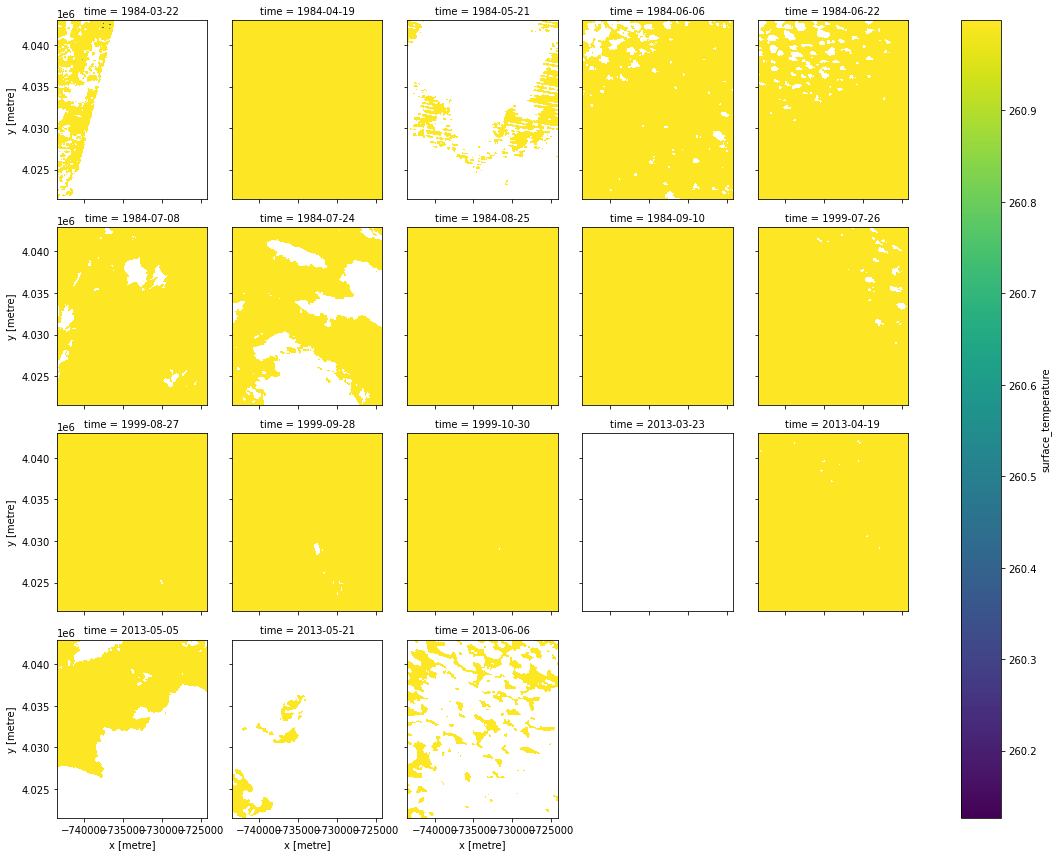

In [5]:
ld.surface_temperature.plot(col='time', col_wrap=5)

## dc.load

In [ ]:
ds = dc.load(product='ls8_c2l2',
             measurements=measurements,
             **query
            ).compute()

# ds = dc.load(product='ls7_c2l2',
#              measurements=measurements,
#              **query
#             )

# ds = dc.load(product='ls5_c2l2',
# #              measurements=measurements,
#              **query
#             )


In [ ]:
# for band in ds.data_vars:
#     fig,ax=plt.subplots(1,1, figsize=(5,5))
#     ds[band].isel(time=2).plot()
#     ax.set_title(band)

In [ ]:
# import pprint
# pprint.pprint(ds.QA_PIXEL.flags_definition)

In [ ]:
quality_flags_prod = {
                "clear": True,
                "cloud_shadow": "not_high_confidence",
                "nodata": False,
            }

# "cirrus":"not_high_confidence"
pq_mask = masking.make_mask(ds['QA_PIXEL'], **quality_flags_prod)


In [ ]:
ds_masked = odc.algo.keep_good_only(ds, where=pq_mask)#.compute()
ds_masked = odc.algo.to_float(ds_masked, dtype='float32').compute()

In [ ]:
st = ds_masked['surface_temperature'] * 0.00341802 + 149.0 - 273.15

In [ ]:
for i in range(len(ds.time)):
    fig,ax=plt.subplots(1,4, figsize=(15,5), sharey=True)
    pq_mask.isel(time=i).plot(ax=ax[1], add_colorbar=False)
    rgb(ds, index=i, ax=ax[0])
    rgb(ds_masked, index=i, ax=ax[2])
    st.isel(time=i).plot(ax=ax[3])   
       